In [1]:
# Copyright (c) Microsoft Corporation. All rights reserved
# Licensed under the MIT License.
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt

import imageio
import shapely
import rasterio
from rasterio.mask import mask as rio_mask
from shapely import geometry
import cv2

from utils import tcm_algorithms as tcm
from utils import utils
from data import data_interface as DataInterface

In [2]:
RASTERIO_BEST_PRACTICES = dict(
    CURL_CA_BUNDLE='/etc/ssl/certs/ca-certificates.crt',
    GDAL_DISABLE_READDIR_ON_OPEN='EMPTY_DIR',
    AWS_NO_SIGN_REQUEST='YES',
    GDAL_MAX_RAW_BLOCK_CACHE_SIZE='200000000',
    GDAL_SWATH_SIZE='200000000',
    VSI_CURL_CACHE_SIZE='200000000'
)

In [3]:
def show_images(images, titles=None):
    """Function to plot images into a figure"""
    num_images = len(images)
    if titles is not None:
        assert len(titles) == num_images

    fig, axs = plt.subplots(1, num_images, figsize=(num_images*4, 4))
    axs = axs.flatten()
    for i in range(num_images):

        axs[i].imshow(images[i])
        if titles is not None:
            axs[i].set_title(titles[i])
        axs[i].axis("off")
        axs[i].get_xaxis().set_visible(False)
        axs[i].get_yaxis().set_visible(False)

    plt.show()
    plt.close()

In [4]:
def running_mean(x, N):
    # from: https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

def largest_smaller(X, k):
    """Function to fond the index of the largest value in X smaller than k"""
    right_idx = X.searchsorted(k,'right')-1
    return right_idx

## Obtaining temporal S2 imagery from the Microsoft' planetary computer matching Solar Farms geometries.
Link to Planetary Computer: https://planetarycomputer.microsoft.com/

In [29]:
# Add your planetary computer subscription key here

PC_SUBSCRIPTION_KEY = ""

#### Obtain geometries of solar farms. 

Note: If the geom is too detailed the staclient api might fail. In that case consider using the "solar_farms_india_2021_merged_simplified.geojson" vector file.

In [6]:
geoms = utils.get_solar_farm_geoms("../data/", "solar_farms_india_2021_merged.geojson")
len(geoms)

1363

In [7]:
geom_id = 80
buffer = 10

In [8]:
# PC dataloader is instantiated
dataloader = DataInterface.PlanetaryComputerS2DataLoader(geoms, pc_subscription_key=PC_SUBSCRIPTION_KEY)

#### Obtain historical S2 rgb image chips for geometry "geom_id" buffered by "buffer"

In [9]:
%%time
rgb_images, dates = dataloader.get_rgb_chips_from_geom(geom_id, buffer=buffer, show_outline=True)

Returned 40 Items
CPU times: user 717 ms, sys: 52.4 ms, total: 769 ms
Wall time: 20.7 s


In [10]:
print("{} matching image chips found".format(len(rgb_images)))

34 matching image chips found


In [11]:
%%time
data_images, masks, dates = dataloader.get_data_stack_from_geom(geom_id, buffer=buffer)

CPU times: user 594 ms, sys: 24.6 ms, total: 619 ms
Wall time: 14.4 s


In [12]:
%%time
divergence_values = tcm.calculate_change_values(data_images, masks, n_clusters=64, use_minibatch=True)

CPU times: user 31.7 s, sys: 2.29 s, total: 33.9 s
Wall time: 7.04 s


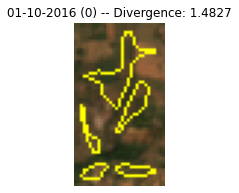

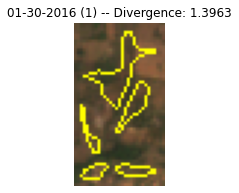

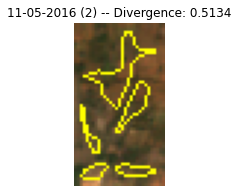

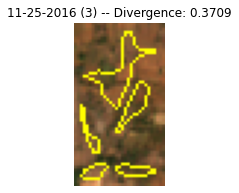

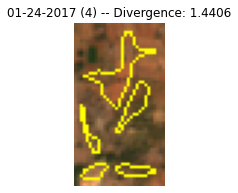

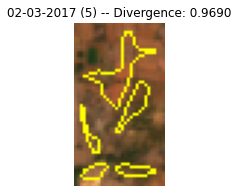

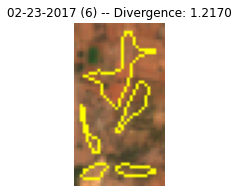

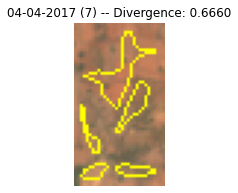

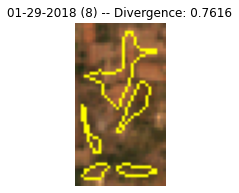

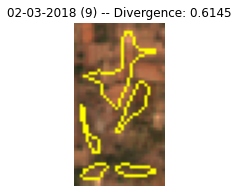

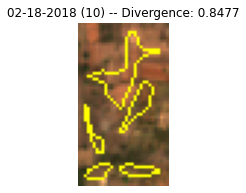

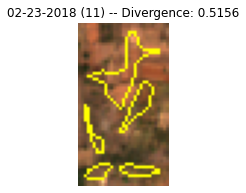

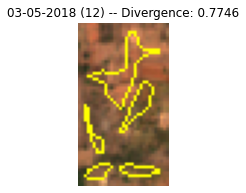

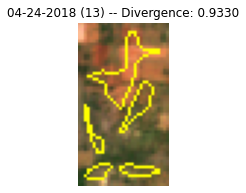

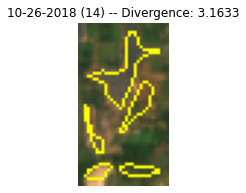

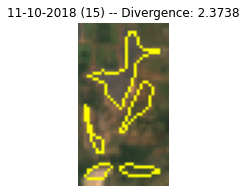

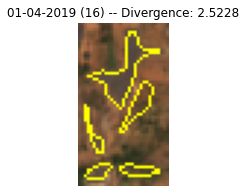

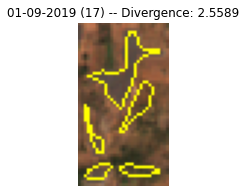

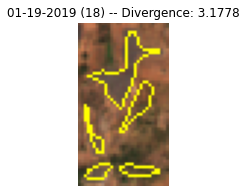

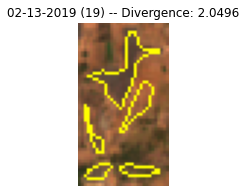

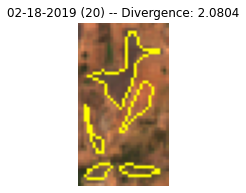

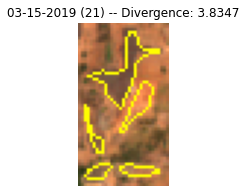

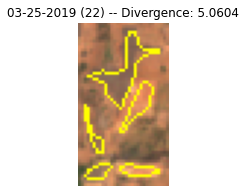

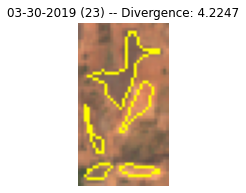

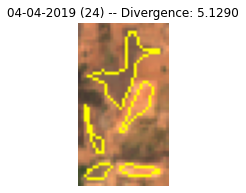

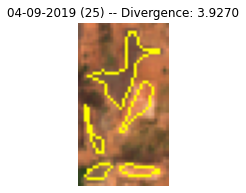

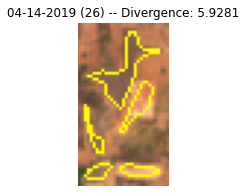

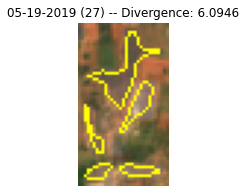

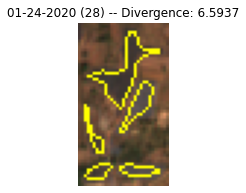

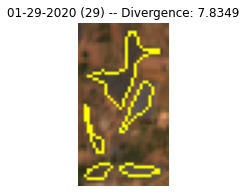

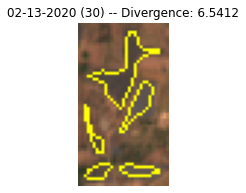

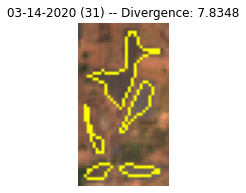

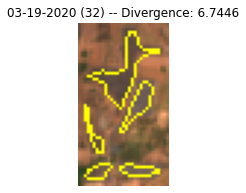

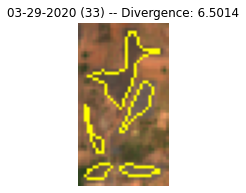

In [13]:
for i in range(len(dates)):
    plt.figure(figsize=(4,3))
    plt.imshow(rgb_images[i])
    plt.axis("off")
    plt.title(f"{dates[i]} ({i}) -- Divergence: {divergence_values[i]:0.4f}")
    plt.show()
    plt.close()

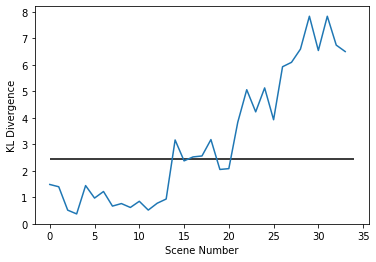

In [14]:
plt.figure()
plt.plot(divergence_values)
plt.hlines(y=np.median(divergence_values), xmin=0, xmax=len(divergence_values), color='k')
plt.xlabel("Scene Number")
plt.ylabel("KL Divergence")
plt.show()
plt.close()

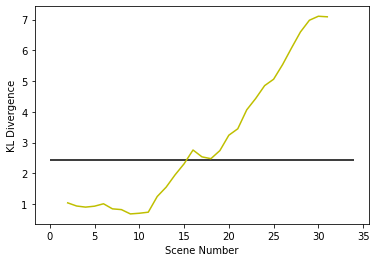

In [15]:
window = 5
half_window = window//2
smoothed_divergence_values = running_mean(divergence_values,window)
plt.figure()
plt.plot(range(half_window,len(divergence_values)-half_window), smoothed_divergence_values, color='y')
plt.hlines(y=np.median(divergence_values), xmin=0, xmax=len(divergence_values), color='k')
plt.xlabel("Scene Number")
plt.ylabel("KL Divergence")
plt.show()
plt.close()

In [16]:
tcm_offset = 1
built_idx = largest_smaller(smoothed_divergence_values, np.median(divergence_values)) + tcm_offset

In [17]:
print("The solar farm is estimated to be built by: "+ dates[built_idx])

The solar farm is estimated to be built by: 10-26-2018


### Images before and after Solar Farm was built

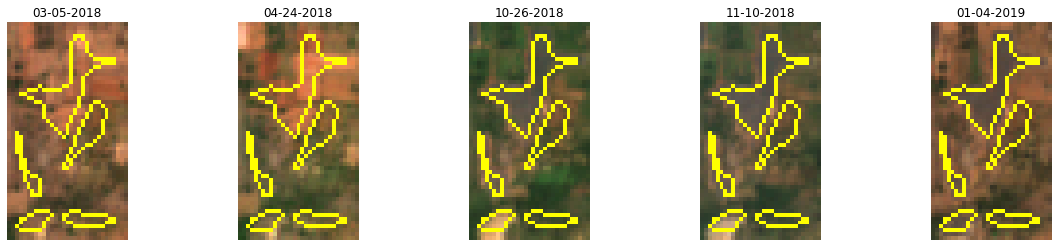

In [18]:
show_images(rgb_images[built_idx - 2: built_idx + 3 ], dates[built_idx - 2: built_idx + 3 ])

## Estimating LULC before Solar Farms was built

Note: This demo uses publicly available 100 m Copernicus Global Land Cover Layers from https://www.mdpi.com/2072-4292/12/6/1044 for demostration purposes. Link to data: https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_Landcover_100m_Proba-V-C3_Global


Paper results mostly uses NRSC Land Use Land Cover

In [19]:
landcover_urls = [
        "../data/landcover/2015_landcover_india.tif",
        "../data/landcover/2016_landcover_india.tif",
        "../data/landcover/2017_landcover_india.tif",
        "../data/landcover/2018_landcover_india.tif",
        "../data/landcover/2019_landcover_india.tif"
    
]

In [20]:
landcover_cl = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100, 111, 112, 113, 114, 115, 116, 121, 122, 124, 125, 126, 200]
landcover_cl_text = ["Unknown", "Shrubs", "Herbaceous vegetation", "Cultivated and managed vegetation / agriculture", 
                     "Urban / built up", "Bare / sparse vegetation", "Snow and ice", "Permanent water bodies",
                    "Herbaceous wetland", "Moss and lichen", "Closed forest, evergreen needle leaf", "Closed forest, evergreen broad leaf",
                    "Closed forest, deciduous needle leaf", "Closed forest, deciduous broad leaf", "Closed forest, mixed",  
                    "Closed forest", "Open forest, evergreen needle leaf.", "Open forest, evergreen broad leaf.", "Open forest, deciduous needle leaf.",
                    "Open forest, deciduous broad leaf", "Open forest, mixed.", "Open forest", "Oceans, seas" ]
c2i = {cl:i for i,cl in enumerate(landcover_cl)}
colors = np.array([[40, 40, 40],[255, 187, 34],[255, 255, 76],[240, 150, 255],[250, 0, 0], [180, 180, 180], [240, 240, 240], [0, 50, 200], [0, 150, 160], [250, 230, 160], [88, 72, 31], [0, 153, 0], [112, 102, 62], [0, 204, 0],[78, 117, 31], [0, 120, 0], [102, 96, 0], [141, 180, 0], [141, 116, 0], [160, 220, 0], [146, 153, 0], [100, 140, 0], [0, 0, 128]])/255.


def vis_lc(r):
    r = np.squeeze(r)
    z = np.zeros((3,) + r.shape)
    r = np.array([(r==landcover_cl[i]) for i in range(len(landcover_cl))])
    s = r / r.sum(0)
    for c in range(len(landcover_cl)):
        for ch in range(3):
            z[ch] += colors[c,ch] * s[c]
    z = np.rollaxis(z, 0, 3)
    
    return z

In [21]:
def get_mask_and_bounding_geoms(geom, buffer):
    footprint_shape = shapely.geometry.shape(geom).buffer(0.0)
    bounding_shape = footprint_shape.envelope.buffer(buffer).envelope
    mask_geom = shapely.geometry.mapping(bounding_shape - footprint_shape) # full bounding area - initial footprint
    bounding_geom = shapely.geometry.mapping(bounding_shape) # full bounding area
    return mask_geom, bounding_geom

def get_landcover_stack_from_geom(geom, buffer, urls):
    mask_geom, bounding_geom = get_mask_and_bounding_geoms(geom, buffer)
    images = []
    labels = []
    for url in urls:
        with rasterio.Env(**RASTERIO_BEST_PRACTICES):
            with rasterio.open(url) as f:
                mask_image, _ = rio_mask(f, [mask_geom], crop=True, invert=False, pad=False, all_touched=True)

                full_image, _ = rio_mask(f, [bounding_geom], crop=True, invert=False, pad=False, all_touched=True)
                landcover = vis_lc(full_image)
        images.append((landcover))
        labels.append((full_image))
    return images, labels

In [22]:
landcover, landcover_classes = get_landcover_stack_from_geom(geoms[geom_id], buffer=0, urls=landcover_urls)

In [23]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

dates_list = [datetime.strptime(date, '%m-%d-%Y').date() for date in dates]
before_built_date= dates_list[built_idx] - relativedelta(years=1)
print(before_built_date)

2017-10-26


In [24]:
year=str(before_built_date.year)
landcover_idx = [i for i, j in enumerate(landcover_urls) if year in j]

imagery_idx = [i for i, j in enumerate(dates) if year in j]

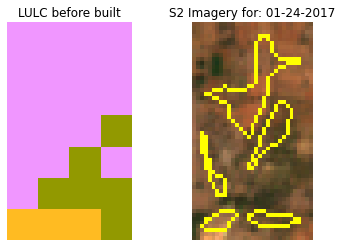

In [25]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(landcover[landcover_idx[0]])
axarr[0].set_title(f"LULC before built")
axarr[0].axis("off")
axarr[1].imshow(rgb_images[imagery_idx[0]])
axarr[1].set_title(f"S2 Imagery for: " + dates[imagery_idx[0]])
plt.axis("off")
plt.show()


In [26]:
lc, counts = np.unique(landcover_classes[landcover_idx[0]], return_counts=True)

In [27]:
max_count = max(counts)
landcover_mode = lc[list(counts).index(max_count)]

In [28]:
print("The most common LCLU class for where this solar farm was built was: ",landcover_cl_text[list(landcover_cl).index(landcover_mode)])

The most common LCLU class for where this solar farm was built was:  Cultivated and managed vegetation / agriculture
